# Predicting Newsletter Subscription from Minecraft Gameplay Behavior
DSCI 100 – Group 11 Final Report


## Introduction


#### Background

Newsletters are commonly used in games to share updates and community information.
Some players choose to subscribe while others do not, and this difference may relate to player characteristics.
Our goal was to explore whether simple demographic information collected from players of `PLAICraft.ai` could help explain subscription behaviour. This project evaluates whether simple characteristics such as Age and self-reported Experience can meaningfully predict whether a user subscribes.

#### Research Questions

`Broad Question`: 

What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

`Specific Question`: 

Can Age and Experience predict subscription status?

#### Dataset
The `player.csv`  dataset contains information describing the users. It is contains 196 observations (players) and 7 variables about them. 

The dataset contains an imbalance in subscription status (~ 73% subscribed), affecting model performance


| Variable | Type | Meaning |  |
|---|---|---|---|
experience | chr | experience level of player | "Pro", "Veteran", "Regular", "Amateur", "Beginner" |
subscribe | lgl| player is subscribed to newsletter or not | TRUE or FALSE |
hashedEmail | chr | player email as identifier | hashed for anonymity
played_hours | dbl | total hours played in game |
name | chr | player name |
gender | chr | player gender | Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say |
Age | dbl | player age | 9 - 58 |

###### *Table 1*

#### Libraries

The necessary libraries for the analysis are loaded.

In [33]:
library(tidyverse)
library(tidymodels)
library(themis)
library(cowplot)

#### Load and Wrangle `Players.csv`

Through a URL to the dataset in the GitHub repository, the `players.csv` dataset is loaded. The dataset also contains NA values, which are removed, and the `subscribe` and `experience` variables are converted into factors suitable for modelling. We converted `experience` into an ordered factor because K-NN Classification requires numeric inputs, which are automatically created during preprocessing by one-hot encoding factors.

In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/players.csv")

player_data <- player_data |>
filter(Age != is.na(Age)) |>
mutate(subscribe = as.factor(subscribe),
       experience = as.factor(experience))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### `Players.csv` Summary

##### Numerical Columns

The summary statistics mean, minimum, maximum, standard deviation, mode and quartiles of the numerical columns (`Age`, `played_hours`) are computed.

In [34]:
player_data_age_hours <- select(player_data,played_hours, Age)

player_data_numeric_summaries <- 
    bind_cols(summary = c("Mean","Minimum","Maximum", "Standard Deviation", "Mode",
                          "1st Quartile", "2nd Quartile", "3rd Quartile"),
              bind_rows(map_df(player_data_age_hours, mean, na.rm = TRUE), #mean
                        map_df(player_data_age_hours, range, na.rm = TRUE), #min + max
                        map_df(player_data_age_hours, sd, na.rm = TRUE), #std dev
                        
                        bind_cols(played_hours = group_by(player_data_age_hours, played_hours) |>  #mode
                                          summarize(count = n()) |>slice_max(count) |> pull(played_hours), 
                                  Age = group_by(player_data_age_hours, Age) |> summarize(count = n()) |>
                                          slice_max(count) |> pull(Age)),
                        tibble(played_hours = quantile(pull(player_data_age_hours,played_hours), #quartiles
                                                       c(0.25, 0.5, 0.75), na.rm = TRUE),
                               Age = quantile(pull(player_data_age_hours,Age), 
                                              c(0.25, 0.5, 0.75), na.rm = TRUE)))) |>
    mutate(across(played_hours:Age, round, 2)) #rounding

player_data_numeric_summaries

summary,played_hours,Age
<chr>,<dbl>,<dbl>
Mean,5.9,21.14
Minimum,0.0,9.00
Maximum,223.1,58.00
Standard Deviation,28.5,7.39
Mode,0.0,17.00
1st Quartile,0.0,17.00
2nd Quartile,0.1,19.00
3rd Quartile,0.6,22.75


###### *Table 1.1*

##### Non-numeric Columns

The number of observations of each distinct value and the percentage of observations they represent is computed for `experience`, `subscribe` and `gender`.

In [44]:
player_data_category <- select(player_data, experience, subscribe, gender)

experience_summary <- player_data_category |> group_by(experience) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))
subscribe_summary <- player_data_category |> group_by(subscribe) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))                      
gender_summary <- player_data_category |> group_by(gender) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2)) 

experience_summary
print("Table 1.2")
subscribe_summary
print("Table 1.3")
gender_summary
print("Table 1.4")

experience,number,percent_total
<fct>,<int>,<dbl>
Amateur,63,32.47
Veteran,48,24.74
Beginner,35,18.04
Regular,35,18.04
Pro,13,6.70


[1] "Table 1.2"


subscribe,number,percent_total
<fct>,<int>,<dbl>
TRUE,142,73.2
FALSE,52,26.8


[1] "Table 1.3"


gender,number,percent_total
<chr>,<int>,<dbl>
Male,124,63.92
Female,37,19.07
Non-binary,15,7.73
Prefer not to say,11,5.67
Two-Spirited,5,2.58
Agender,2,1.03


[1] "Table 1.4"


#### Exploratory Visualizations

##### Experience vs Subscription — Proportion Plot

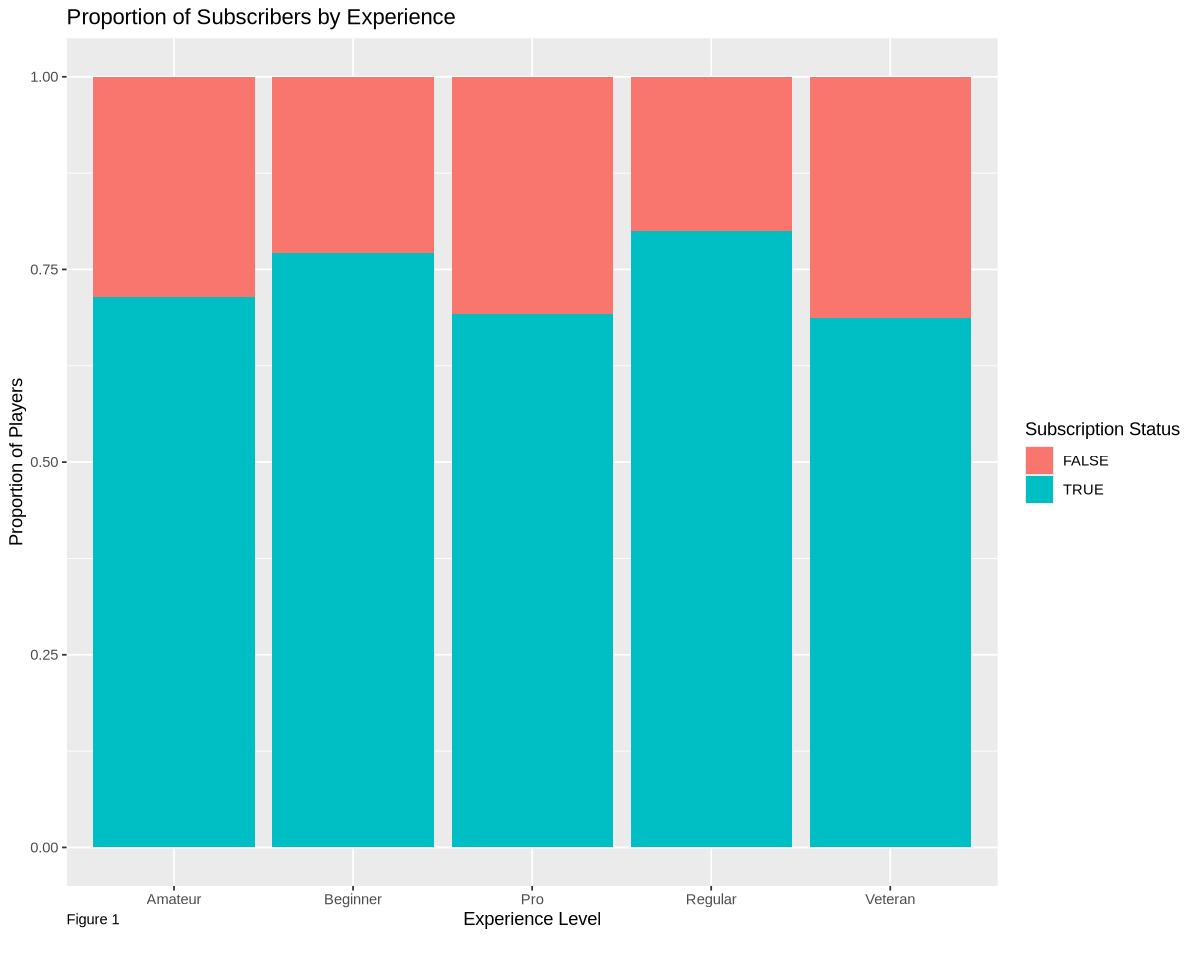

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribers by Experience", 
     x = "Experience Level", 
     y = "Proportion of Players",
    fill = "Subscription Status",
    caption = "Figure 1") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The proportion of subscribed vs not-subscribed players is roughly the same across experience levels as seen in Figure 1. This may indicate that experience is not a strong predictor of whether a player is likely to subscribe.

##### Experience vs Subscription — Count Plot

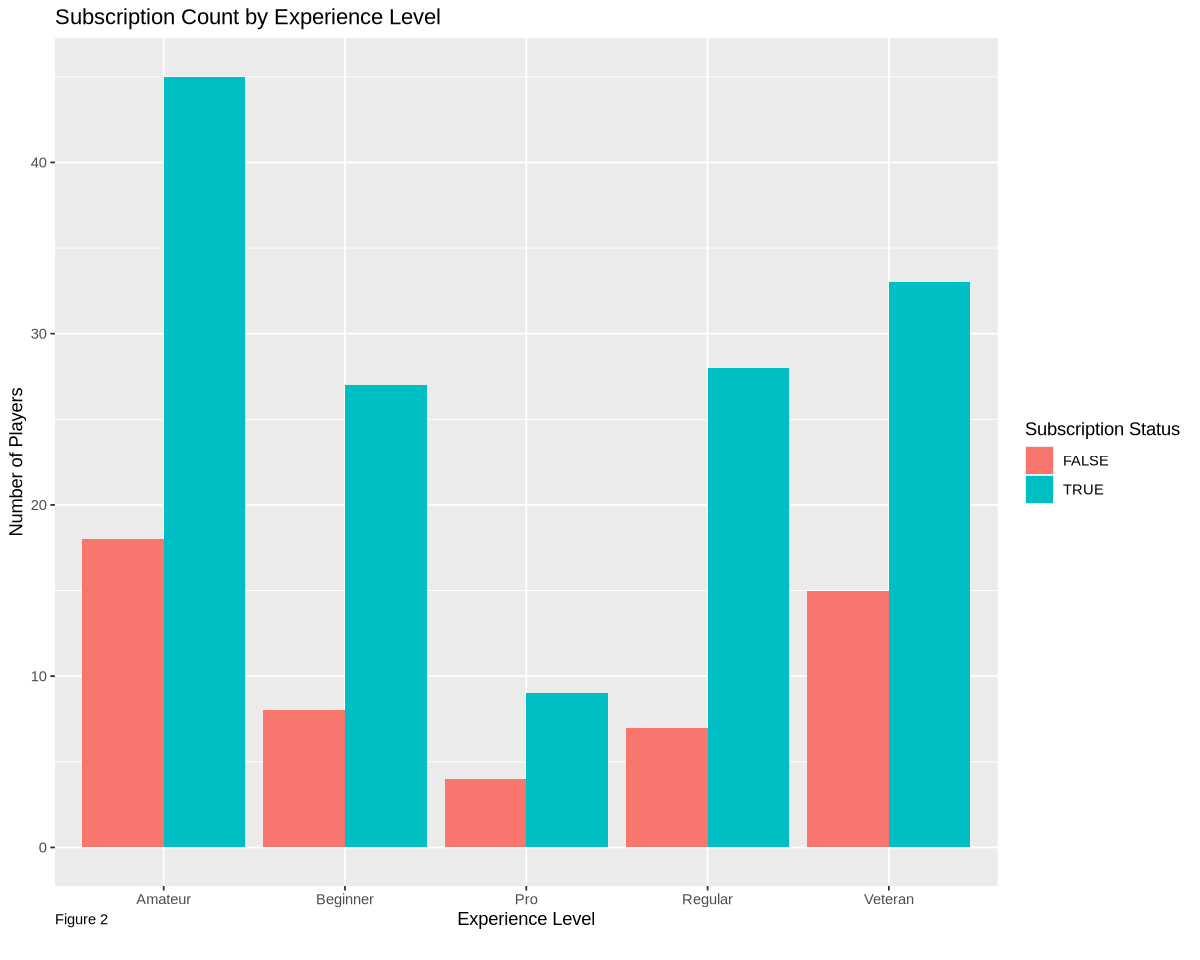

In [6]:
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Subscription Count by Experience Level",
       x = "Experience Level",
       y = "Number of Players",
      fill = "Subscription Status",
      caption = "Figure 2") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The number of total players per experience level is not equal across them (as seen in Figure 2), potentially leading to the model having difficulty predicting the less represented experience levels such as "Pro".

##### Age vs Subscription — Quartile Distribution Plot

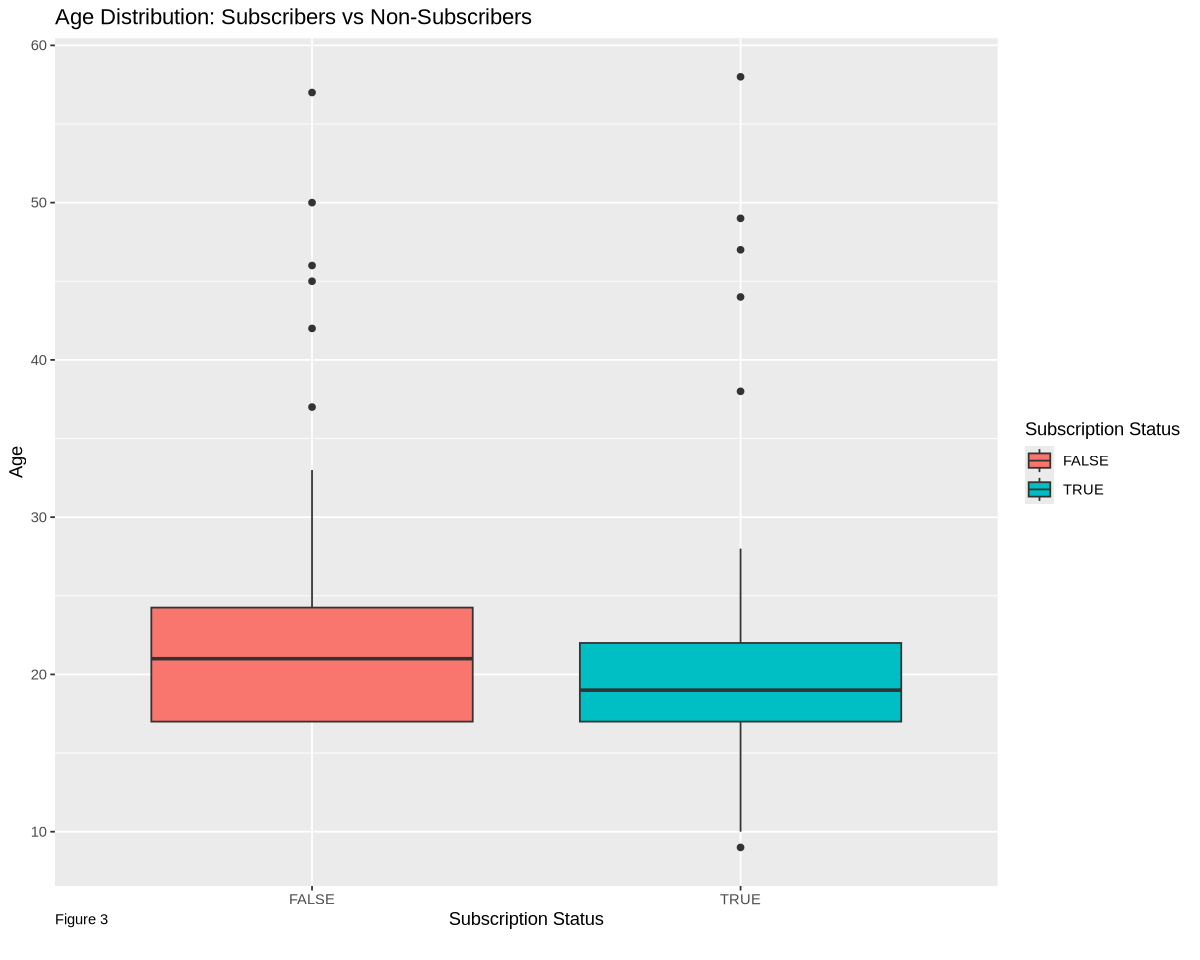

In [7]:
ggplot(player_data, aes(x = subscribe, y = Age, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Age Distribution: Subscribers vs Non-Subscribers",
       x = "Subscription Status",
       y = "Age",
       fill = "Subscription Status",
      caption = "Figure 3") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The median age for subscribed players is lower for those who subscribe than those who do not and the interquartile is also more compact than the interquartile for non subscribed players.

##### Age vs Subscription — Count Plot

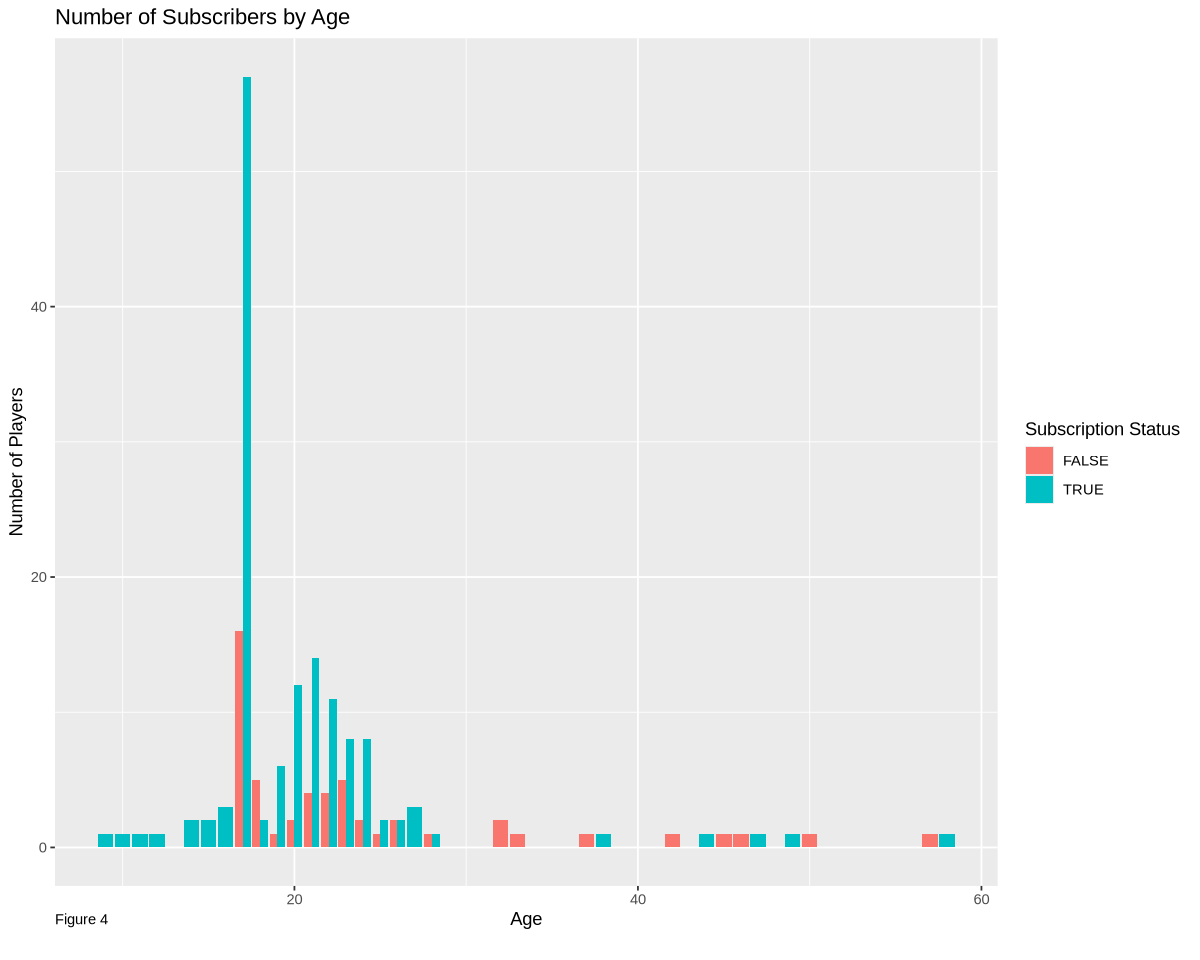

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = Age, fill = subscribe)) +
geom_bar(position = "dodge") +
labs(title = "Number of Subscribers by Age", 
     x = "Age", 
     y = "Number of Players",
    fill = "Subscription Status",
    caption = "Figure 4") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

The majority of player ages are between 10 and 30, with 17 being the age with the most players. In general, ages with fewer players are more likely to to be entirely subscribed/not subscribed.

#### Training and Testing Split and 5-fold Data Separation

Here the `player_data` is split into 75% training and  25% testing datasets, then the training portion is grouped into 5 folds for later use in cross validation.

In [9]:
set.seed(1)
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

#### K-NN Classification Tuning Models

Individual recipes were created for `Age`, `experience` and `Age` + `experience`, where the `Age` predictor was stardardized for each recipe it is present in. These recipes were used as a manual forward selection process to determine the best combination of the the two variables to be used in the final classification model. A tuning model was also created and used along with the recipes and odd K values from 1 to 75 to determine the resulting accuracy via cross validation at each K value based on each recipe.

In [10]:
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 2))

knn_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
                step_normalize(all_predictors())

knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train)

knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train) |>
                step_normalize(Age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

age_tune <- workflow() |>
            add_recipe(knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

experience_tune <- workflow() |>
            add_recipe(knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

both_tune <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

#### K-NN Tune Model Plots

Created visualizations of the accuracy at each K value for each model formed by the individual recipes. 

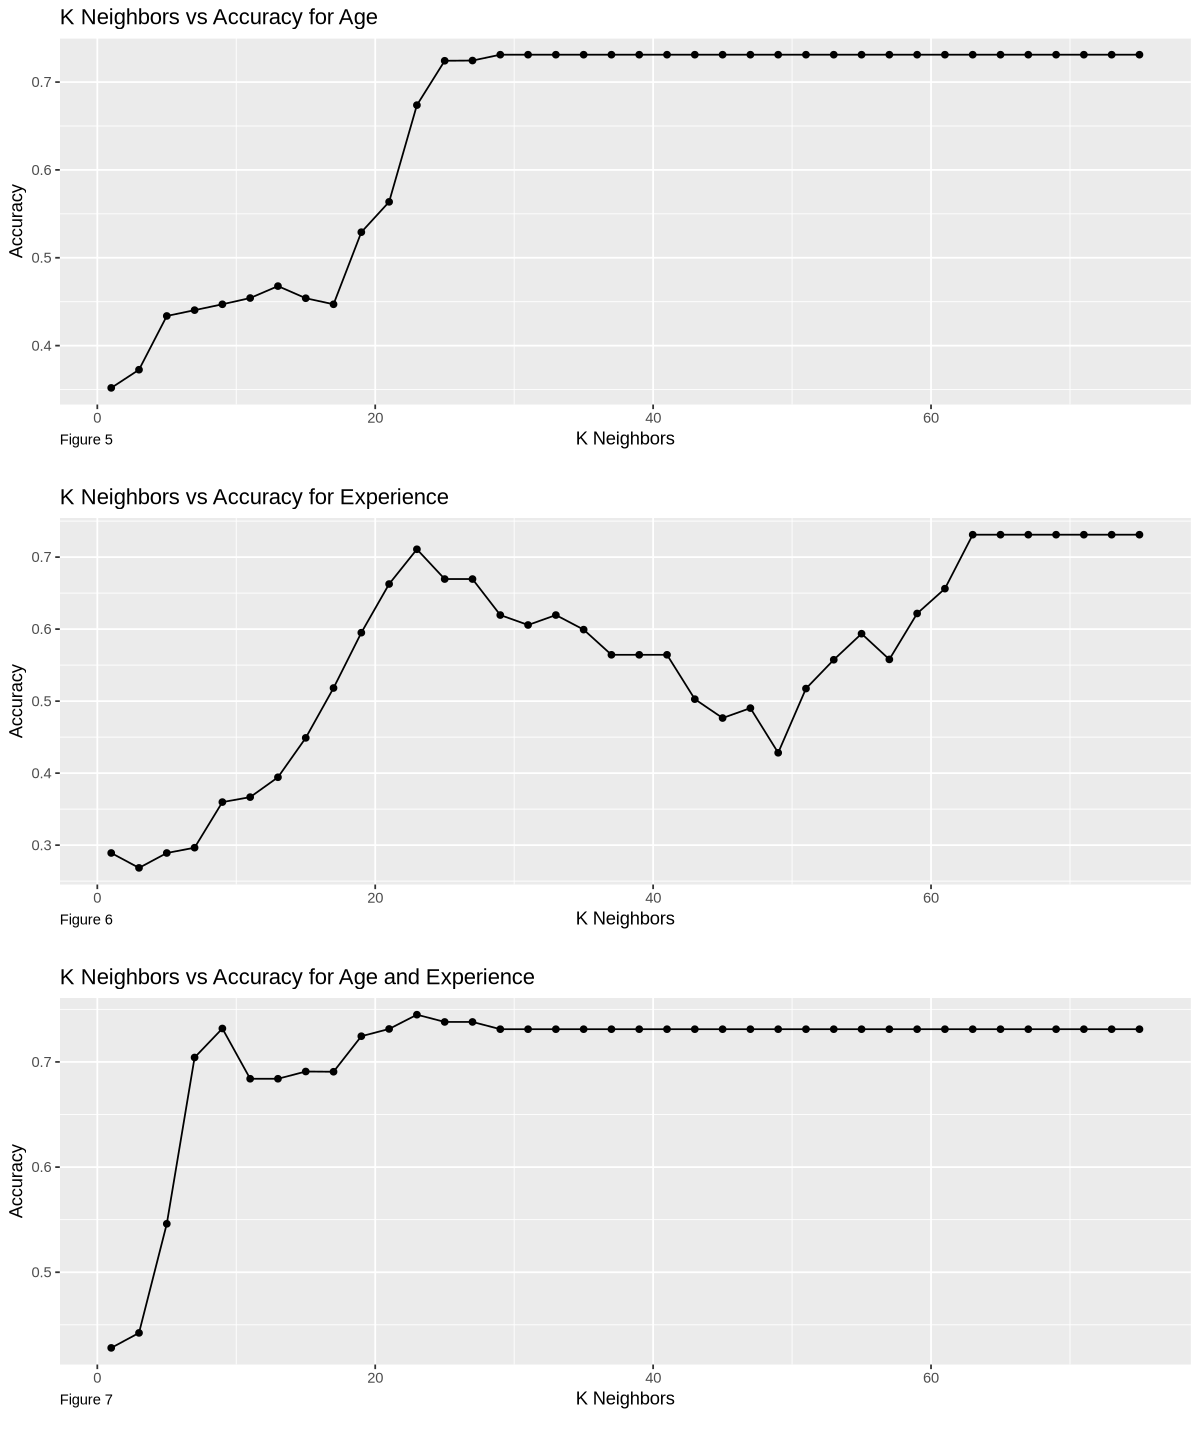

In [11]:
options(repr.plot.width = 10, repr.plot.height = 12)
age_tune_plot <- age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 5") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

experience_tune_plot <- experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience", 
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 6") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

both_tune_plot <- both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 7") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(age_tune_plot,
          experience_tune_plot,
          both_tune_plot, ncol = 1)

### Tuning Results
*Age Only Plot:*
- No clear accuracy peak
- As K increases past 13, accuracy drops, then begins to spike up at k = 17.
- Starting at K = 29, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Age alone does not meaningfully seem to separate subscribers from non-subscribers.

*Experience Only Plot:*
- Accuracy peaks at around K = 23
- As K increases past 23, accuracy drops erratically, reaching a relative low at k = 49 before again spiking up and underfitting
- Experience seems to have a stronger influence on the model than age; however, it does not appear to have too strong a relationship with subscription, since the accuracy of the model is erratic. Thus, Experience seems to affect prediction more than Age but is still weak.

*Age and Experience Plot:*
- Highest overall accuracy value
- Accuracy peaks at around K = 23
- As K increases past 9, accuracy dips briefly before climbing to reach its peak
- As K increases past 29, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Combined, both predictors seem to have improved (but still limited) performance, with accuracy being slightly higher than just using `Age` or `Experience`

#### Select Predictors and K Value

Find the K value(s) with the highest accuracy for each model.

In [37]:
max_age_accuracy <- age_tune |> 
                slice_max(mean)
max_experience_accuracy <- experience_tune |>
                        slice_max(mean)
max_both_accuracy <- both_tune |>
                    slice_max(mean)
# max_age_accuracy        # <- max accuracy = 0.7311494 @ 29-75 neighbors
# max_experience_accuracy # <- max accuracy = 0.7311494 @ 63-75 neighbors
# max_both_accuracy       # <- max accuracy = 0.7449425 @ 23 neighbors

The `Age` and `experience` model was chosen since it has the highest accuracy of the three models and K = 23 was selected for it because it has the greatest accuracy and the surrounding points do not have drastically different accuracies.

#### K-NN Model and Prediction

A classification model is created with 23 neighbors, trained on the `player_train` dataset, and the model is used on the `player_test` dataset to predict the `subscribe` values.

In [13]:
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec_tuned) |>
            fit(player_train)


player_predict <- predict(knn_fit, player_test) |>
                bind_cols(player_test)

#### Proportion of Subscribe Values in `player_test`

Calculated proportions for later comparision.

In [14]:
player_test |> group_by(subscribe) |> summarize(proportion = n()/nrow(player_test))

subscribe,proportion
<fct>,<dbl>
FALSE,0.2653061
TRUE,0.7346939


###### *Table 2*

#### Accuracy of Model

In [15]:
prediction_accuracy <- player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


###### *Table 3*

The accuracy of the model (Table 3) is the same number as the proportion of *TRUE* subscribe values in the `player_test` dataset (Table 2). If the model were to blindly "predict" only *TRUE*, it would have the same accuracy, therefore making it a not very effective classification model likely due to class imbalance.

#### Precision and Recall (*TRUE* as Positive)

In [16]:
prediction_precision_t <- player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall_t <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")
bind_rows(prediction_precision_t, prediction_recall_t)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7555556
recall,binary,0.9444444


###### *Table 4*

The recall is fairly high, however, "predicting" all *TRUE* would actually yield a better recall, since every *TRUE* value would be correctly predicted. In terms of precision, this is where the model is slightly better than just predicting *TRUE*. Based on the fact that the precision is higher than the proportion of *TRUE* values, it implies that the model had some correct *FALSE* predictions.

#### Precision and Recall (*FALSE* as Positive)

In [17]:
prediction_precision_f <- player_predict |> # FALSE is the first event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "first")

prediction_recall_f <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "first")
bind_rows(prediction_precision_f, prediction_recall_f)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5000000
recall,binary,0.1538462


###### *Table 5*

A precision of .500 means the model correctly predicted *False* 50% of the time, and a recall of 0.154 means very few of the *FALSE* values were predicted *FALSE*.

#### Confusion Matrix of Model

In [18]:
prediction_conf_mat <- player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)
prediction_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     11   34

###### *Table 6*

From the confusion matrix in Table 5, it can be seen that *TRUE* was predicted 45 out of 49 times; however, of the 45 predictions, only 34 were correct. *FALSE* was predicted only 4 times, and only 2 of those were correct. The bias to mostly predicting *TRUE* is most likely due to the imbalance of *TRUE* and *FALSE* values in `subscribe`, which can be addressed through upsampling. Additionally, overall, there are few observations in the dataset which limit how well the model can be trained.

#### Model Visualisation

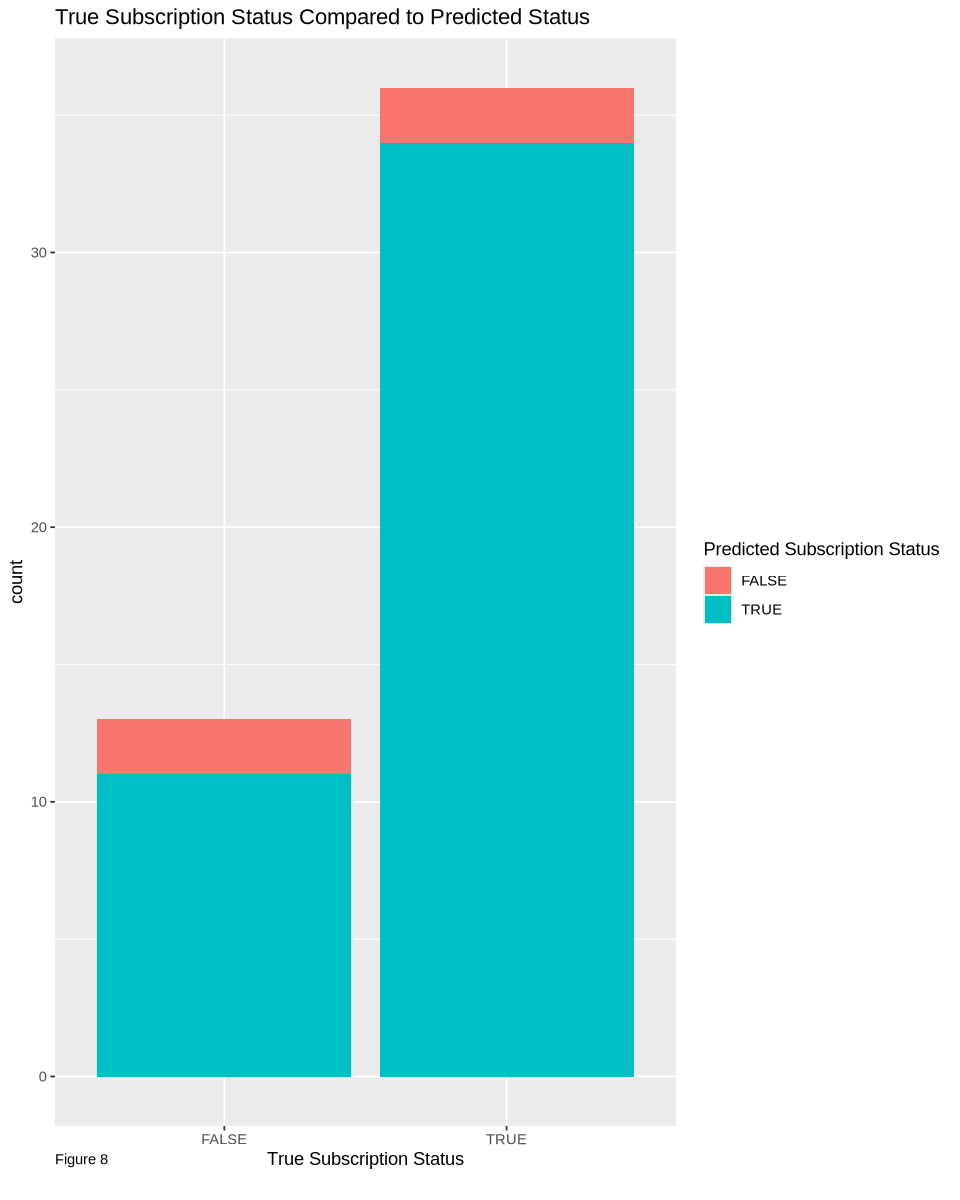

In [31]:
options(repr.plot.width = 8, repr.plot.height = 10)
player_predict |>
ggplot(aes(x = subscribe, fill = .pred_class))+
geom_bar() +
labs(x = "True Subscription Status", fill = "Predicted Subscription Status", caption = "Figure 8") +
ggtitle("True Subscription Status Compared to Predicted Status") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

Visual representation of the confusion matrix in Table 6.

#### Next Steps: Upsampling

In our dataset, the outcome variable subscribe is imbalanced, with about 73% of players subscribed and 27% not subscribing. Upsampling artificially increases the number of minority-class observations (*FALSE* for subscribe) by increasing the amount of *FALSE* until a 1:1 class balance is achieved. K-NN is heavily biased towards the majority class, so without upsampling, it predicts *TRUE* almost all the time, giving high accuracy but failing to identify non-subscribers. Upsampling improves the model's ability to make balanced predictions and learn meaningful patterns. Downsampling is another option that achieves the same 1:1 ratio; however, it reduces the majority class down to the number of observations in the minority class, which when considering the already small size of the data set, further limits how well the model can be trained and therefore will not be used.

#### Upsample Training Data and 5-fold Data Separation

Set the seed to ensure reproducibility, then created a recipe to upsample the training dataset, before prepping and baking it to the training dataset to make a 1:1 ratio of *TRUE* and *FALSE*. Then created the 5-fold separation with the upsampled data.

In [39]:
set.seed(1)
player_train_upsampled <- recipe(subscribe ~ Age + experience, data = player_train) |>
                            step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
                             prep(retain = TRUE) |>
                             bake(new_data = NULL)

player_vfold_upsampled <- vfold_cv(player_train_upsampled, v = 5, strata = subscribe)

#### Upsampled K-NN Tuning Models

Same process as with the original model, except the upsampled training dataset is used.

In [41]:
balanced_knn_recipe_age <- recipe(subscribe ~ Age, data = player_train_upsampled) |>
                            step_normalize(all_predictors())

balanced_knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train_upsampled)

balanced_knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train_upsampled) |>
                            step_normalize(Age)


balanced_age_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_experience_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_both_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

#### Upsampled K-NN Tune Model Plots

Same process as with the original model, except the upsampled training dataset is used.

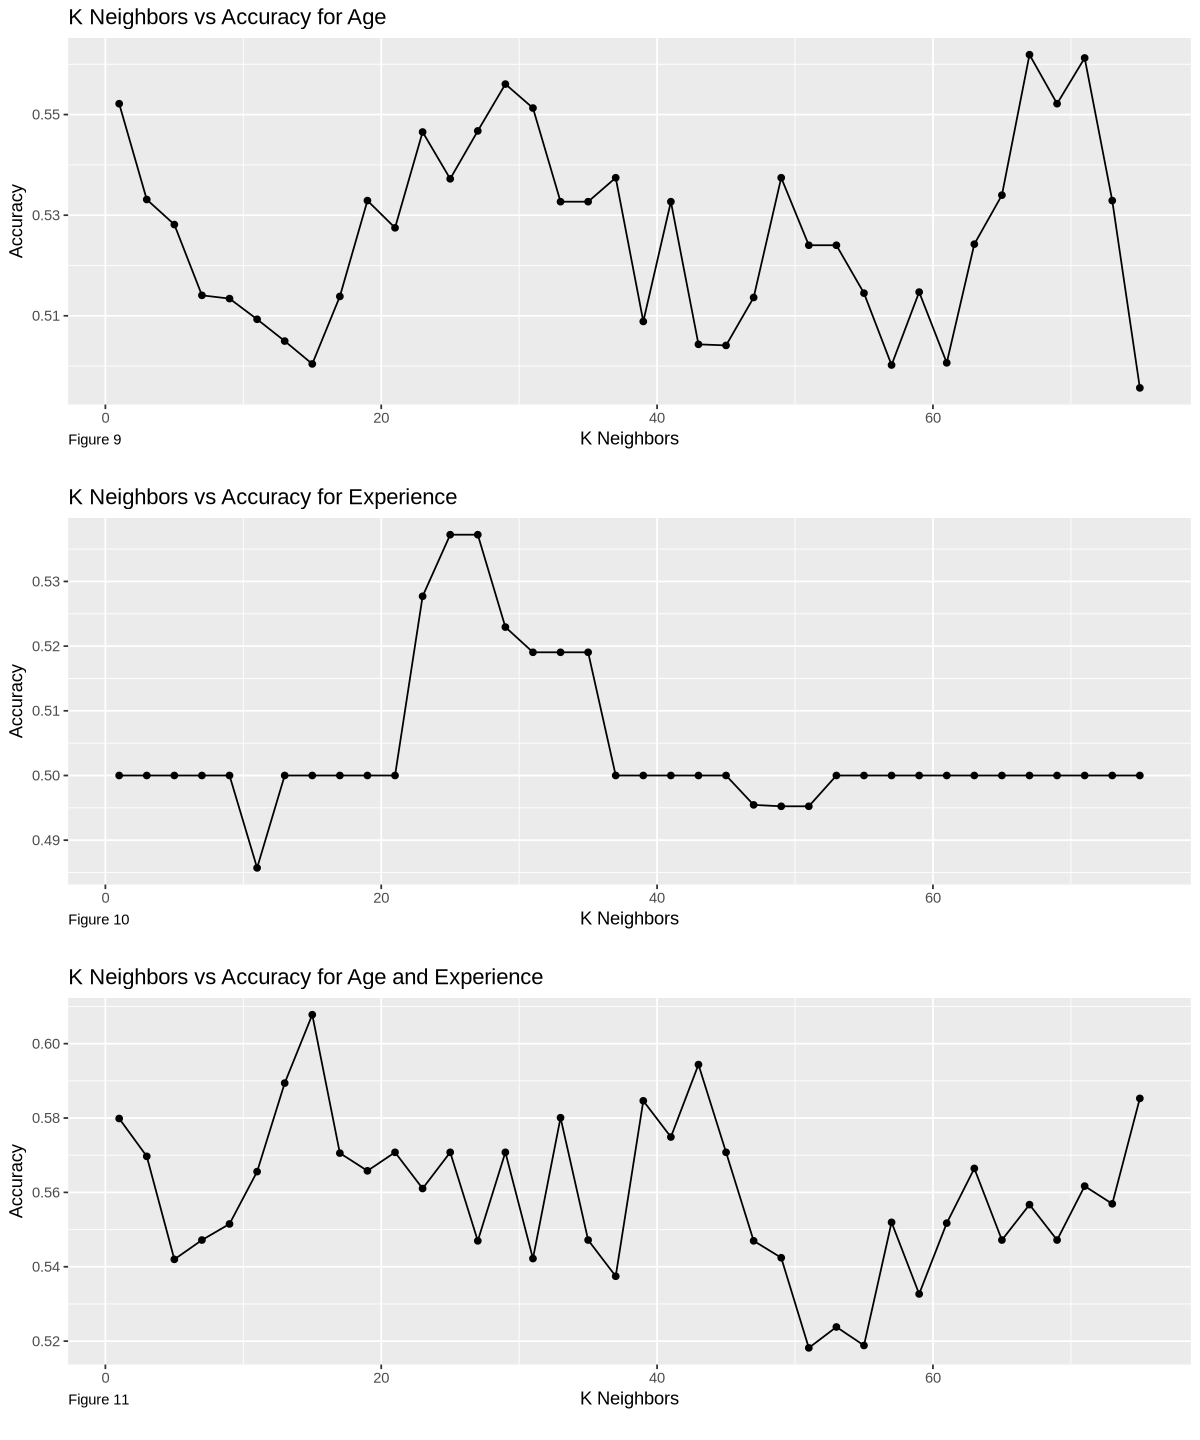

In [32]:
options(repr.plot.width = 10, repr.plot.height = 12)
balanced_age_tune_plot <- balanced_age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 9") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_experience_tune_plot <- balanced_experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 10") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_both_tune_plot <- balanced_both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 11") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(balanced_age_tune_plot,
          balanced_experience_tune_plot,
          balanced_both_tune_plot, ncol = 1)

After upsampling, our predictions differ a bit. Both predictors seem pretty weak, only being about 50-60% accurate. However, using both predictors gives us the highest accuracy of around 61% at K = 15, showing that the predictors do seem to have a partial relation to subscription. Perhaps if the sample size were larger, we could confidently determine whether these variables are strong predictors or not.

#### Select Predictors and K Value of Upsampled

In [23]:
balanced_max_age_accuracy <- balanced_age_tune |> 
                slice_max(mean)
balanced_max_experience_accuracy  <- balanced_experience_tune |>
                        slice_max(mean)
balanced_max_both_accuracy  <- balanced_both_tune |>
                    slice_max(mean)
# balanced_max_age_accuracy       # <- max accuracy  = 0.5619048 @ 67 neighbors
# balanced_max_experience_accuracy  # <- max accuracy  = 0.5372294 @ 25-27 neighbors
# balanced_max_both_accuracy        # <- max accuracy  = 0.6077922 @ 15 neighbors

Although K = 15 has the highest accuracy for the `Age` + `Experience` model, as can be seen in Figure 11, it is located at a large spike with the surrounding K values' accuracy being sizeably lower, indicating it is not a reliable choice and may not perform as well on other data, therefore being a suboptimal choice. The highest peak with the least variation before and after the point is the optimal K value to select, and from Figure 11, that value is K = 21 since the 4 nearest points only change a maximum of ~0.01. Due to this reasoning, K = 21 will be used in the upsampled model.

#### Upsampled K-NN Model and Prediction

Created a K-NN classification model using 21 neighbors, then, along with the recipe using `Age` and `experience` predictors from the upsampled training data, fit it to the upsampled training data. That model was then used to predict the `subscribe` values in the original `player_test` data.

In [24]:
balanced_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                set_engine("kknn") |>
                set_mode("classification")

balanced_knn_fit <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(balanced_knn_spec_tuned) |>
            fit(player_train_upsampled)

balanced_player_predict <- predict(balanced_knn_fit, player_test) |>
                bind_cols(player_test)

#### Accuracy of Upsampled Model

In [25]:
balanced_prediction_accuracy <- balanced_player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
balanced_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


###### *Table 7*

The accuracy of the upsampled model (0.612, Table 7) is lower than the accuracy of the original model (0.735, Table 3), which in general implies it is worse. This could be due to training the model on a 50/50 subscription while the testing data was 73/27, or there being no strong relationships present.

#### Precision and Recall of Upsampled Model (*TRUE* as Positive)

In [26]:
balanced_prediction_precision_t <- balanced_player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_recall_t <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

bind_rows(balanced_prediction_precision_t, balanced_prediction_recall_t)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8148148
recall,binary,0.6111111


###### *Table 8*

From Table 8, it can be seen that the precision for *TRUE* of the upsampled model (0.815, Table 8) is higher than the original model (0.756, Table 4), meaning it predicted *TRUE* when the actual value was *FALSE* fewer times. In contrast, recall is lower since the upsampled model correctly predicted *TRUE* fewer times.

#### Precision and Recall of Upsampled Model (*FALSE* as Positive)

In [27]:
balanced_prediction_precision_f <- balanced_player_predict |> # FALSE is the first event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "first")

balanced_prediction_recall_f <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "first")

bind_rows(balanced_prediction_precision_f, balanced_prediction_recall_f)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.3636364
recall,binary,0.6153846


###### *Table 9*

*FALSE* was predicted for *TRUE* values more times than in the original model, leading to a lower precision (shown in Table 9). Recall, however, is significantly better, indicating this model is better at correctly predicting if a player will not subscribe.

#### Confusion Matrix of Upsampled Model 

In [28]:
balanced_prediction_conf_mat <- balanced_player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)
balanced_prediction_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     8   14
     TRUE      5   22

###### *Table 10*

As seen in Table 10, the upsampled model predicted *TRUE* 27 out of 49 times. Of those 27 *TRUE* predictions, 22 were correct, and of its 22 *False* predictions, 8 were correct. This model had much more distribution to its predictions as opposed to the original model mostly predicting *TRUE*.

#### Upsampled Model Visualisation

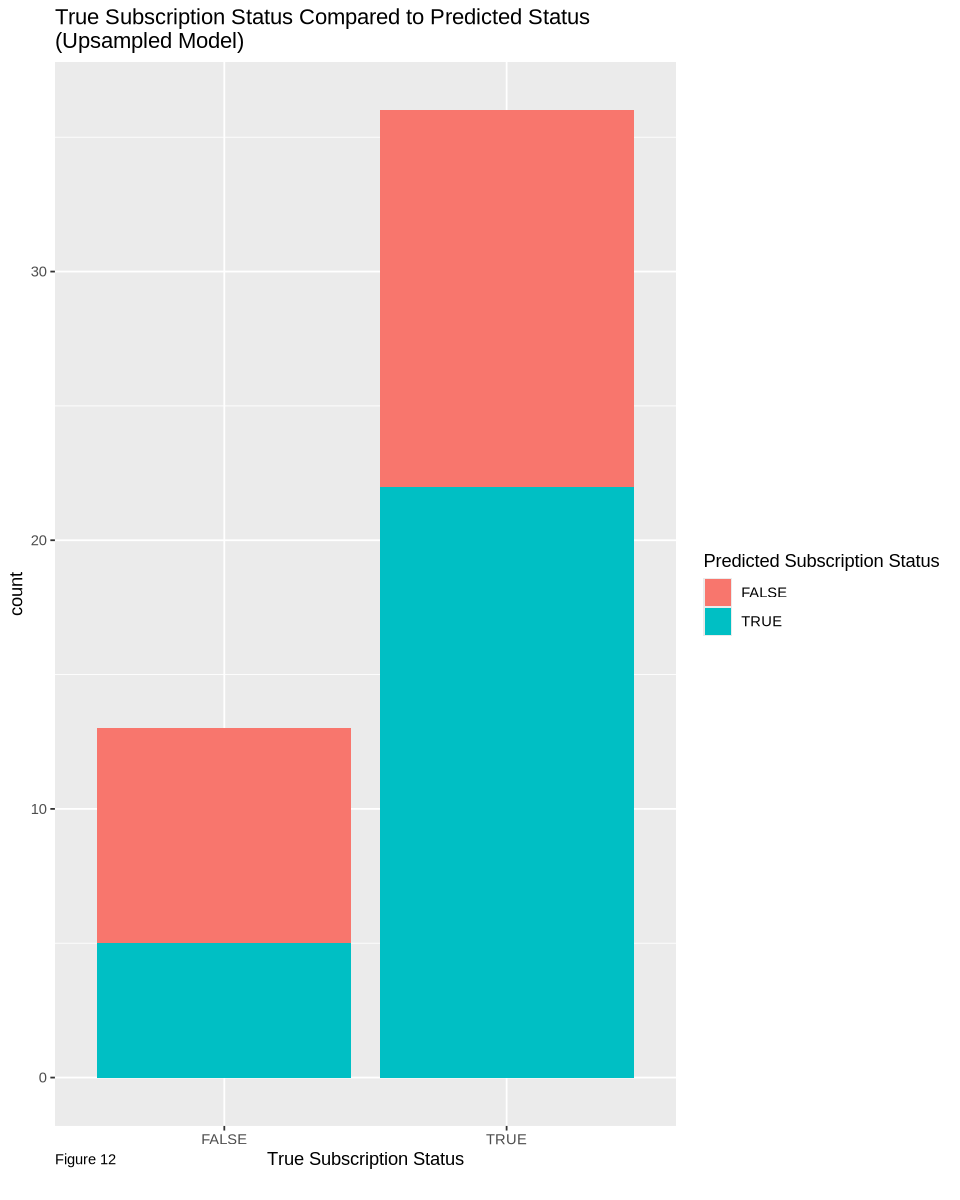

In [30]:
options(repr.plot.width = 8, repr.plot.height = 10)
balanced_player_predict |>
ggplot(aes(x = subscribe, fill = .pred_class))+
geom_bar() +
labs(x = "True Subscription Status", fill = "Predicted Subscription Status", caption = "Figure 12") +
ggtitle("True Subscription Status Compared to Predicted Status\n(Upsampled Model)") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

Visual representation of the confusion matrix in Table 10.

### Discussion:

*Summarize what you found:*
- We found that `Experience` and `Age` can be used to predict newsletter subscription, but are weak predictors overall. We found that using both `Experience` and `Age` (Figure 7) is the most accurate, followed by `Experience` alone (Figure 6), and then `Age` alone (Figure 5). However, after being upsampled, accuracy is only slightly better than randomly picking *TRUE* or *FALSE*. `Age` (Figure 9) is around the same as `Experience` (Figure 10), both having abyssmally low accuracies of around 55%. After upsampling, the highest accuracy when using both predictors (Figure 11) is only around 61%.

*Is this what we expected to find?:*
- This is not unexpected, as Figure 1 showed that different `Experience` levels had very similar subscription proportions, meaning not much predictability between different experience levels. `Age` also seems pretty weak as a predictor, with a seemingly pretty weak relation with subscription. The data given was also pretty poor, with a small sample size and an imbalance of *TRUE* and *FALSE* subscribe values limiting the potential for a well trained model.

*Discuss what impact such findings could have:*
- These results show that simple demographic variables are insufficient for predicting subscription behaviour in this game. Developers should not rely on Age or Experience alone when targeting newsletter subscriptions. Subscriptions appear to be influenced by factors beyond simple static demographics. Including additional variables could significantly improve model performance and provide more insights as to why players choose to subscribe.
- Game Studios might want to invest in collecting and analyzing more metrics to better identify players who most likely want to engage with their content. These new studies can also go more in-depth into the relationship between Age, Experience level, and newsletter subscription.

*Discuss what future questions this could lead to:*
- Would a larger dataset strength relationships?
- Can `gender` or `played_hours` also predict newsletter subscription?
- Is a player's average session length a good predictor of their likelihood to subscribe to a newsletter?

#### Conclusion

Our results show that neither `Age` nor `Experience` is a strong predictor of newsletter subscription of `PLAICraft.ai` players. While combining the predictors gives us slightly better accuracy than using either alone, the improvement is minor. After correcting the class imbalance, the prediction power drops significantly. This suggests that subscription behavior depends on other factors, such as engagement-based features or behavioral metrics.